# Análisis estadístico del dataset PH2

En este cuaderno, se analiza estadísticamente las características del dataset de PH2 y sus metadatos disponibles

In [9]:
# SET UP Fastai
%pip install -Uqq fastbook
%pip install nbdev

Note: you may need to restart the kernel to use updated packages.
  Using cached nbdev-2.3.13-py3-none-any.whl.metadata (10 kB)
  Using cached execnb-0.1.5-py3-none-any.whl.metadata (3.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached ghapi-1.0.4-py3-none-any.whl.metadata (13 kB)
Using cached nbdev-2.3.13-py3-none-any.whl (66 kB)
Using cached execnb-0.1.5-py3-none-any.whl (13 kB)
Using cached ghapi-1.0.4-py3-none-any.whl (58 kB)
Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
Note: you may need to restart the kernel to use updated packages.


In [21]:
import fastbook
fastbook.setup_book()
import fastai
import fastcore
print(f'fastcore version {fastcore.__version__} installed')
print(f'fastai version {fastai.__version__} installed')
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import csv
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

fastcore version 1.5.29 installed
fastai version 2.7.14 installed


Las siguientes funciones ayudan a observar los datos


In [97]:
'''
This function receives a string with the filename of the image to read,
and a flag indicating if we want to read it in color/RGB (flagColor=1) or gray level (flagColor=0)

Example of use:
im1=readIm(get_image('apple.jpg'),0)

'''
def readIm(filename, flagColor=1):
    # cv2 reads BGR format
    im=cv2.imread(filename)
    # change to  RGB and return the image
    if(flagColor):
        return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    # change from BGR to grayscale instead if flag is 0
    return cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
'''
This function receives an array of arbitrary real numbers (that could include even negative values),
and returns an 'image' in the range [0,1].
flag_GLOBAL allows the user to normalize the whole image (including all channels) or to normalize
each channel/band independently.
'''
def rangeDisplay01(im, flag_GLOBAL= True):
    im = im.astype(float)
    if flag_GLOBAL:
        im = (im - im.min())/(im.max() - im.min())
    else:
        # bands normalization
        for band in range(im.shape[2]):
            im[:, :, band] = (im[:, :, band] - im[:, :, band].min())/(im[:, :, band].max() - im[:, :, band].min())
            # Note: remember that, for plt.imshow with RGB data, the valid range is [0..1] for floats and [0..255] for integers.
    return im

'''
This function displays a single image, including a title, using a magnification factor.

Example of use:
im1=readIm(get_image('apple.jpg'),0)
displayIm(im1,'Manzana',0.5)

'''
def displayIm(im, title='Result',factor= 2):
    # First normalize range
    max=np.max(im)
    min=np.min(im)
    if min<0 or max>255:
        im=rangeDisplay01(im,flag_GLOBAL=True)
    if len(im.shape) == 3:
        # im es tribanda
        plt.imshow(im, cmap='jet')
    else:
        # im es monobanda
        plt.imshow(im, cmap='gray')
    figure_size = plt.gcf().get_size_inches()
    plt.gcf().set_size_inches(factor * figure_size)
    plt.title(title)
    plt.xticks([]), plt.yticks([]) # eliminamos numeración
    plt.show()

# This function display the KeyPoints of an image
def showKP(im,kp,title):
    im_orig = im.copy()
    for curKey in kp:
        x=np.int(curKey.pt[0])
        y=np.int(curKey.pt[1])
        size = np.int(curKey.size)
        cv2.circle(im,(x,y),40,color=(255,0,0), thickness=4)
    displayIm(im, title)

## Lectura de metainformación

Se leerá el fichero .csv asociado a las imágenes para obtener información estadística y las asignar las etiquetas disponibles

In [20]:
# Lectura del xls
df_original = pd.read_excel('PH2_dataset.xlsx',skiprows=range(0,12))
display(df_original)

,Image Name,Histological Diagnosis,Common Nevus,Atypical Nevus,Melanoma,Asymmetry\n(0/1/2),Pigment Network\n(AT/T),Dots/Globules\n(A/AT/T),Streaks\n(A/P),Regression Areas\n(A/P),Blue-Whitish Veil\n(A/P),White,Red,Light-Brown,Dark-Brown,Blue-Gray,Black
0,IMD003,NaN,X,NaN,NaN,0,T,A,A,A,A,NaN,NaN,NaN,X,NaN,NaN
1,IMD009,NaN,X,NaN,NaN,0,T,A,A,A,A,NaN,NaN,X,NaN,NaN,NaN
2,IMD016,NaN,X,NaN,NaN,0,T,T,A,A,A,NaN,NaN,X,X,NaN,NaN
3,IMD022,NaN,X,NaN,NaN,0,T,A,A,A,A,NaN,NaN,X,NaN,NaN,NaN
4,IMD024,NaN,X,NaN,NaN,0,T,A,A,A,A,NaN,NaN,X,X,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,IMD424,Melanoma,NaN,NaN,X,2,AT,AT,P,A,P,NaN,NaN,X,X,X,X
196,IMD425,Melanoma,NaN,NaN,X,2,AT,AT,A,P,P,NaN,NaN,X,X,X,X
197,IMD426,Melanoma,NaN,NaN,X,2,AT,A,A,P,A,NaN,NaN,X,X,NaN,NaN
198,IMD429,NaN,NaN,NaN,X,0,AT,A,P,A,P,NaN,NaN,X,X,X,X


Las columnas que contienen una x son aquellas que indican la clase del lunar que se está observando. Puede ser un lunar atípico, o un lunar o comun, o un melanoma. Codificaremos los tres tipos adecuadamente para construir un nuevo csv del que realizar la mezcla y separación train-test.

In [68]:
for index, row in df_original.iterrows():
    # Actualizar los valores de las columnas según alguna lógica
    if row['Common Nevus']=='X':
        df_original.loc[index, 'Common Nevus'] = 1
        df_original.loc[index, 'Atypical Nevus'] = 0
        df_original.loc[index, 'Melanoma'] = 0
    elif row['Atypical Nevus']=='X':
        df_original.loc[index, 'Common Nevus'] = 0
        df_original.loc[index, 'Atypical Nevus'] = 1
        df_original.loc[index, 'Melanoma'] = 0
    elif row['Melanoma']=='X':
        df_original.loc[index, 'Common Nevus'] = 0
        df_original.loc[index, 'Atypical Nevus'] = 0
        df_original.loc[index, 'Melanoma'] = 1


In [71]:
trainPH2 = df_original.copy()
display(trainPH2)

,Image Name,Histological Diagnosis,Common Nevus,Atypical Nevus,Melanoma,Asymmetry\n(0/1/2),Pigment Network\n(AT/T),Dots/Globules\n(A/AT/T),Streaks\n(A/P),Regression Areas\n(A/P),Blue-Whitish Veil\n(A/P),White,Red,Light-Brown,Dark-Brown,Blue-Gray,Black
0,IMD003,NaN,1,0,0,0,T,A,A,A,A,NaN,NaN,NaN,X,NaN,NaN
1,IMD009,NaN,1,0,0,0,T,A,A,A,A,NaN,NaN,X,NaN,NaN,NaN
2,IMD016,NaN,1,0,0,0,T,T,A,A,A,NaN,NaN,X,X,NaN,NaN
3,IMD022,NaN,1,0,0,0,T,A,A,A,A,NaN,NaN,X,NaN,NaN,NaN
4,IMD024,NaN,1,0,0,0,T,A,A,A,A,NaN,NaN,X,X,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,IMD424,Melanoma,0,0,1,2,AT,AT,P,A,P,NaN,NaN,X,X,X,X
196,IMD425,Melanoma,0,0,1,2,AT,AT,A,P,P,NaN,NaN,X,X,X,X
197,IMD426,Melanoma,0,0,1,2,AT,A,A,P,A,NaN,NaN,X,X,NaN,NaN
198,IMD429,NaN,0,0,1,0,AT,A,P,A,P,NaN,NaN,X,X,X,X


Ahora, una vez hemos podido convertir la notación en OneHot enconding, podemos pasar a estudiar la distribución de clases. Para ello, convertiremos a su vez esta notación en un modelo categórico que permita ser entendido fácilmente.

C:\Users\Cris1\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
C:\Users\Cris1\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


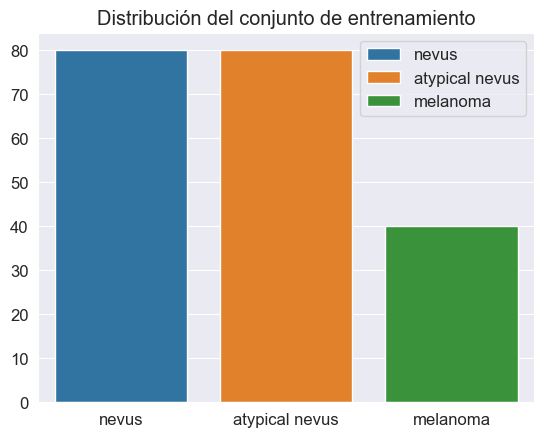

In [82]:
# Extraemos el conteo de cada clase
LABELS = ['nevus','atypical nevus','melanoma']

train_y = np.array(trainPH2.iloc[:,2:5], dtype=int)

# Representamos en un gráfico de barras
sns.barplot(x=LABELS, y=np.sum(train_y, axis=0), hue = LABELS,dodge=False)
plt.title("Distribución del conjunto de entrenamiento")
plt.show()

Ahora, debemos crear un método para acceder a cada imagen dada su id de este mismo dataframe. Para ello, debemos navegar entre las carpetas y extraer una copia de la ID requerida para su procesamiento

In [89]:
def get_image_by_id(df, id):
    nombre = df.loc[df['Image Name'] == id]
    # Buscamos su carpeta
    os.chdir(f"PH2 Dataset images/{id}/{id}_Dermoscopic_Image/")
    image = cv2.imread(f'{id}.bmp')
    os.chdir("../../../")
    
    return image
# Cambiar al directorio especificado

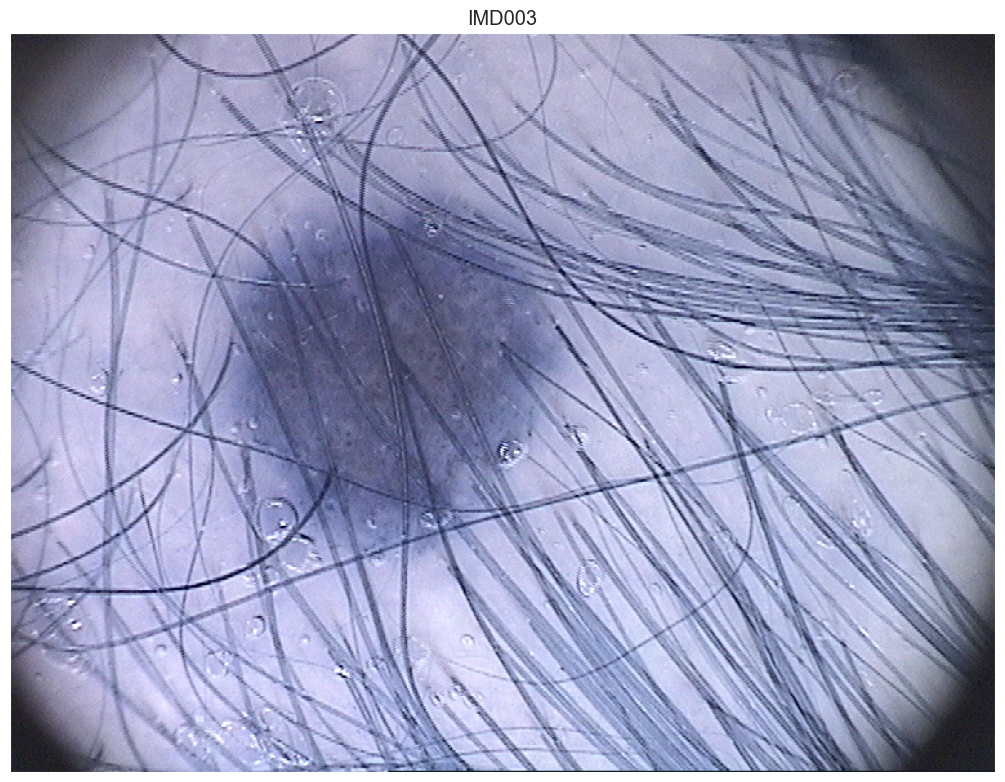

In [99]:
name = 'IMD003'
im = get_image_by_id(trainPH2, name)
displayIm(im, name)